**X-Ray classification**

**Exploratory data analysis**

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. 

You must use at least **2 different architectures**,
* one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and 
* one with a popular CNN pre-trained CNN model (e.g., VGG-19, ResNet, etc.). 

Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found [here](https://stanfordmlgroup.github.io/competitions/mura/). To download the dataset you must fill out a form, so complete this action as soon as possible.

In [1]:
import data_loader
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [2]:
directory = 'data/'

In [3]:
train, test, bodyparts_train_validation_dict, train_generators, valid_generators, test_generators = data_loader.data_loader()


Import train and test data


Create dictionary for training and validation set per body part


Create dictionary for training, validation and test set per body part

Found 4594 validated image filenames.
Found 512 validated image filenames.
Found 461 validated image filenames.
Found 1651 validated image filenames.
Found 174 validated image filenames.
Found 301 validated image filenames.
Found 4996 validated image filenames.
Found 547 validated image filenames.
Found 460 validated image filenames.
Found 1151 validated image filenames.
Found 121 validated image filenames.
Found 288 validated image filenames.
Found 8805 validated image filenames.
Found 947 validated image filenames.
Found 659 validated image filenames.
Found 7550 validated image filenames.
Found 829 validated image filenames.
Found 563 validated image filenames.
Found 4451 validated image filenames.
Found 480 validated image filenames.
Found 465 validated image filenames.
Data munging completed


# EDA
## Check balance of the dataset

In [4]:
def plot_hist_region(df):
  fig  = plt.figure(figsize=(8,4), dpi = 150)
  df['bodypart'].hist(bins = 13, color = 'red')
  plt.xticks(rotation = 90)
  # fig.savefig('hist_train.png', dpi = 150)
  # files.download("hist_train.png")

In [5]:
plot_hist_region(train)

In [6]:
plot_hist_region(test)

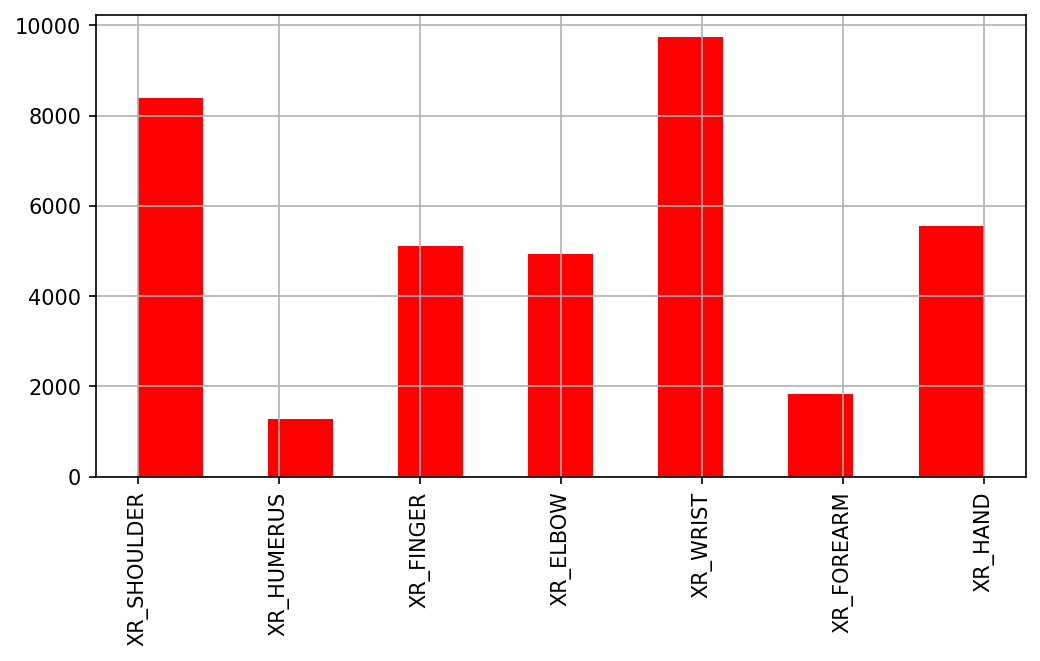

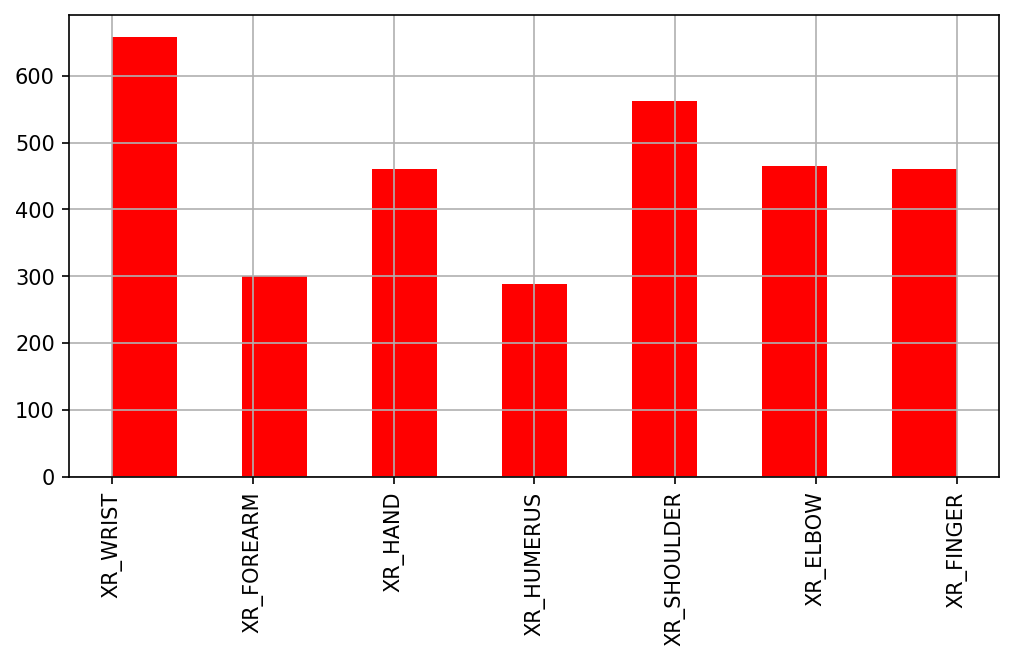

<Figure size 1200x600 with 0 Axes>

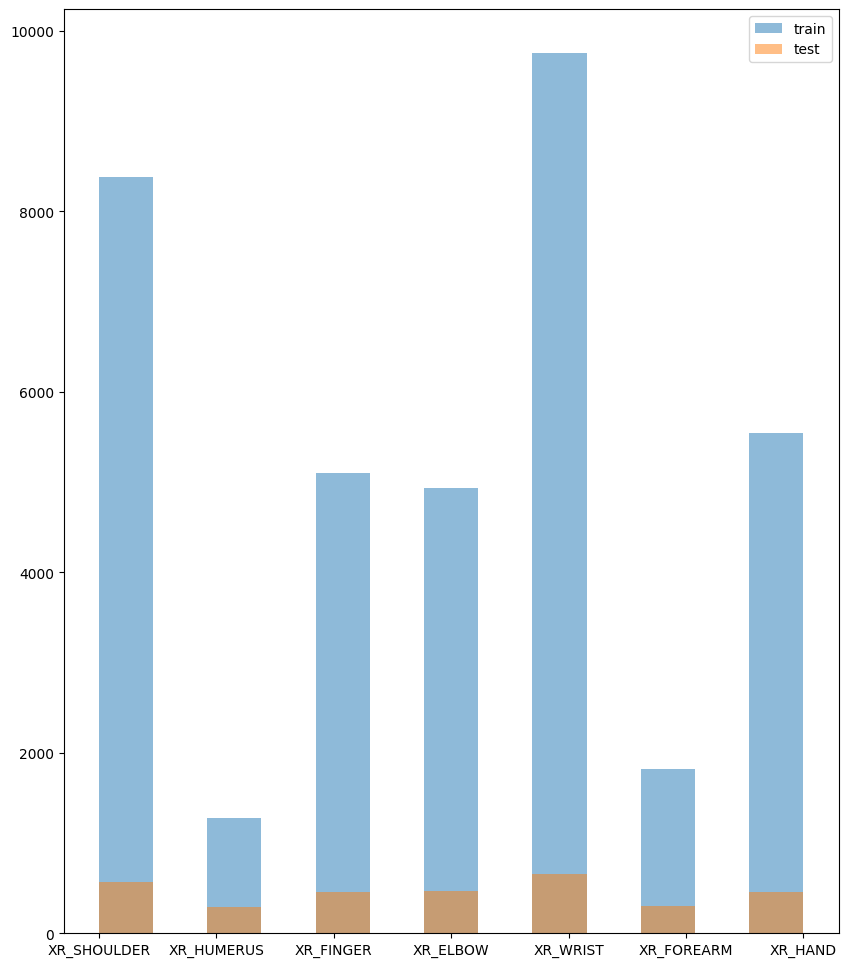

In [7]:
fig  = plt.figure(figsize=(8,4), dpi = 150)
plt.figure(figsize=(10,12))
plt.hist(train['bodypart'], alpha=0.5, bins = 13, label='train')
plt.hist(test['bodypart'], alpha=0.5, bins = 13, label='test')
plt.legend()
plt.show()

In [8]:
def class_counts(df):
  patients_per_bodypart = df.groupby('bodypart')['patient'].count().reset_index()
  patients_per_bodypart.rename(columns={'patient':'patient_count'},inplace=True)
  abnormalities_per_bodypart = df.groupby('bodypart')['class'].sum().reset_index()
  abnormalities_per_bodypart.rename(columns={'class':'abnorm_count'},inplace=True)
  total = patients_per_bodypart.merge(abnormalities_per_bodypart)
  total['normal_count'] = total['patient_count'] - total['abnorm_count']
  total['abnorm_percentage'] = (total['abnorm_count']/total['patient_count'])
  total['normal_percentage'] = (total['normal_count']/total['patient_count'])
  return total

In [9]:
def barplot_per_bodypart(df, name, width): 
  xtick_labels = df['bodypart']
  xtick_position = np.arange(len(xtick_labels))
  fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
  abnorm_bars = ax.bar(xtick_position - width/2, 
                       df['abnorm_count'], 
                       width=width,  
                       label='Abnormal')
  normal_bars = ax.bar(xtick_position + width/2,
                       df['normal_count'], 
                       width=width, 
                       label='Normal')

  for rect in abnorm_bars + normal_bars:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width() / 2.0, 
               height, 
               f'{height:.0f}', 
               ha='center', 
               va='bottom')

  ax.set_title('%s Set'% name)
  ax.set_ylabel('Count')
  ax.set_xticks(xtick_position)
  ax.set_xticklabels(xtick_labels)
  ax.legend()

  fig.suptitle('Count of Abnormal and Normal Results per Bodypart (%s) set' % name)
  plt.show()

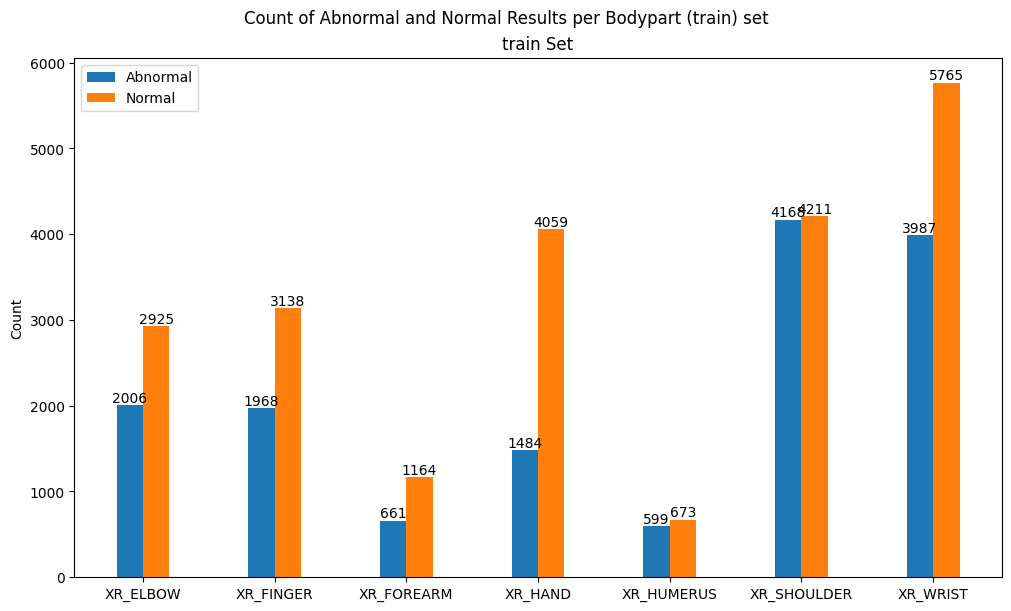

In [10]:
stats_train = class_counts(train)
stats_test = class_counts(test)
barplot_per_bodypart(stats_train, "train", 0.2)

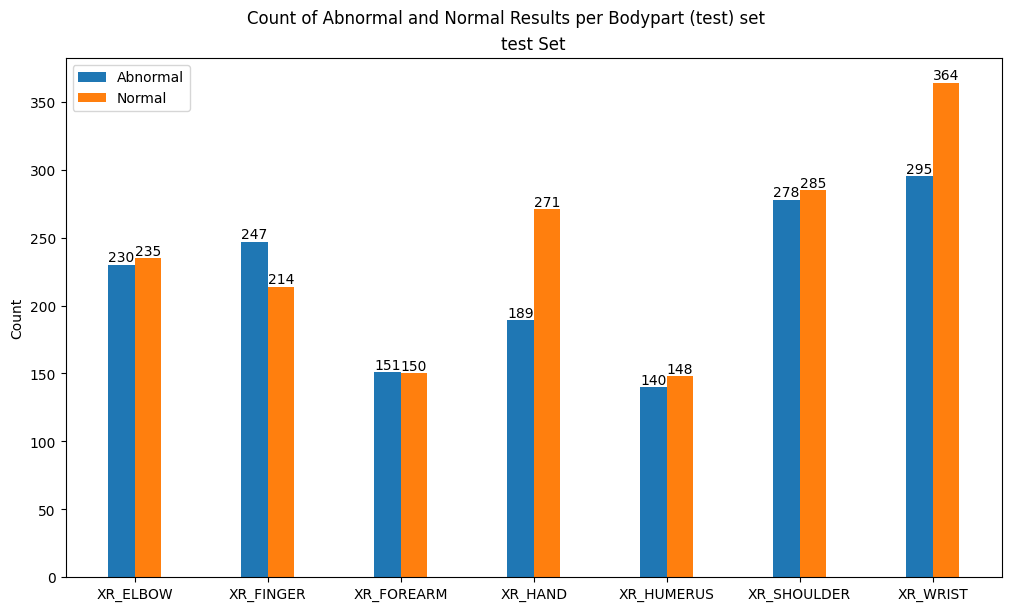

In [11]:
barplot_per_bodypart(stats_test, "test", 0.2)

In [12]:
def balance_calculator(name, df):
    train, valid = df
    print('Training set')
    negative = round(sum(train['class']== 0) / len(train), 2) * 100
    positive = round(sum(train['class']== 1) / len(train), 2) * 100
    print(f"{name}: {negative} % of normal X-rays.")
    print(f"{name}: {positive} % of abnormal X-rays.")
    print('Validation set')
    negative = round(sum(valid['class']== 0) / len(valid), 2) * 100
    positive = round(sum(valid['class']== 1) / len(valid), 2) * 100
    print(f"{name}: {negative} % of normal X-rays.")
    print(f"{name}: {positive} % of abnormal X-rays.")
    print('\n')
    pass 

In [13]:
for bodypart, datasets in bodyparts_train_validation_dict.items():
    balance_calculator(bodypart, datasets)

Training set
XR_FINGER: 62.0 % of normal X-rays.
XR_FINGER: 38.0 % of abnormal X-rays.
Validation set
XR_FINGER: 60.0 % of normal X-rays.
XR_FINGER: 40.0 % of abnormal X-rays.


Training set
XR_FOREARM: 64.0 % of normal X-rays.
XR_FOREARM: 36.0 % of abnormal X-rays.
Validation set
XR_FOREARM: 64.0 % of normal X-rays.
XR_FOREARM: 36.0 % of abnormal X-rays.


Training set
XR_HAND: 73.0 % of normal X-rays.
XR_HAND: 27.0 % of abnormal X-rays.
Validation set
XR_HAND: 71.0 % of normal X-rays.
XR_HAND: 28.999999999999996 % of abnormal X-rays.


Training set
XR_WRIST: 59.0 % of normal X-rays.
XR_WRIST: 41.0 % of abnormal X-rays.
Validation set
XR_WRIST: 57.99999999999999 % of normal X-rays.
XR_WRIST: 42.0 % of abnormal X-rays.


Training set
XR_HUMERUS: 52.0 % of normal X-rays.
XR_HUMERUS: 48.0 % of abnormal X-rays.
Validation set
XR_HUMERUS: 56.99999999999999 % of normal X-rays.
XR_HUMERUS: 43.0 % of abnormal X-rays.


Training set
XR_SHOULDER: 50.0 % of normal X-rays.
XR_SHOULDER: 50.0 % of 

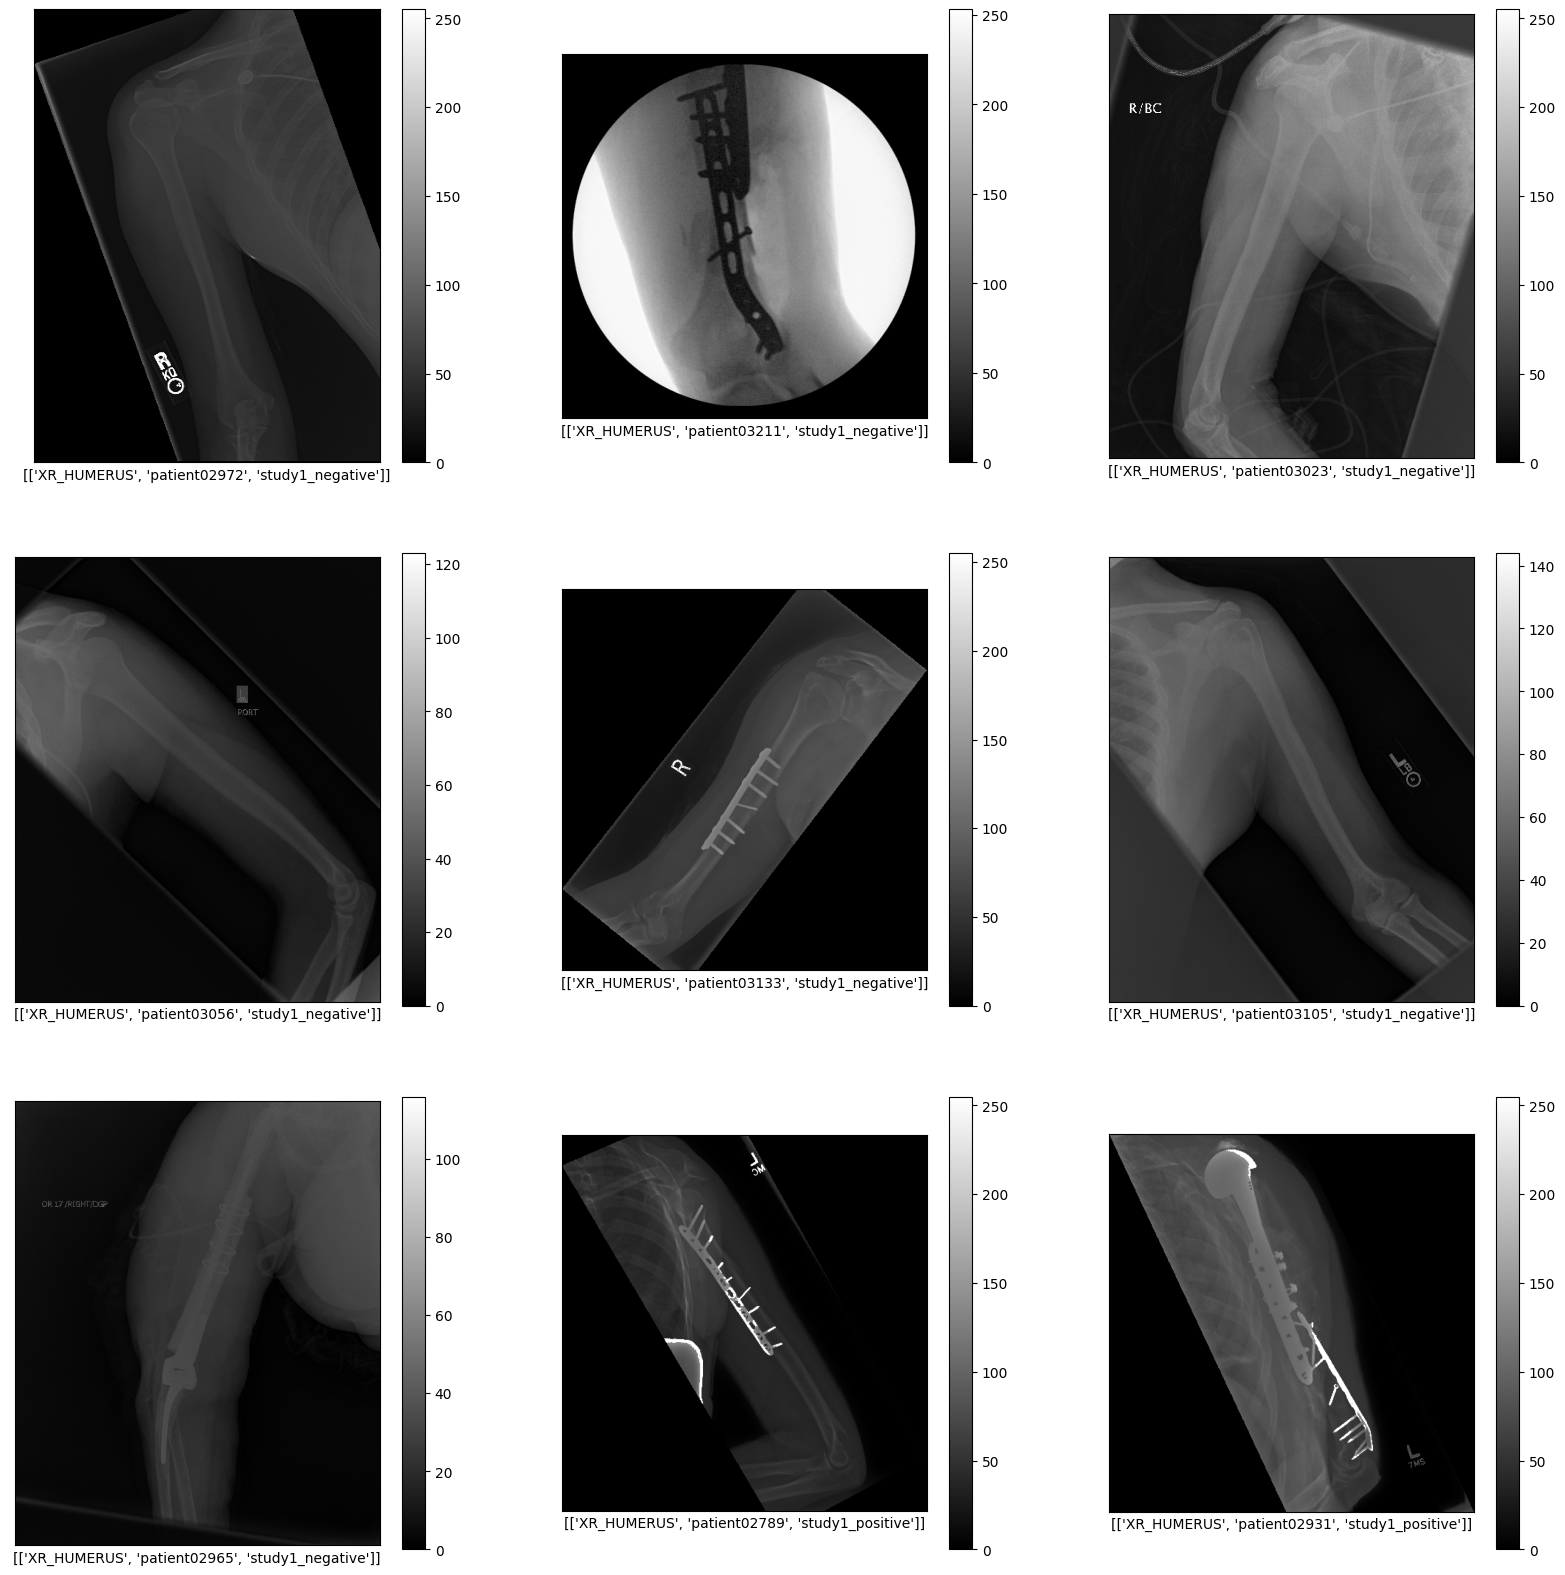

In [14]:
x_train_HUMERUS = bodyparts_train_validation_dict['XR_HUMERUS'][0]['img_path']
y_train_HUMERUS = bodyparts_train_validation_dict['XR_HUMERUS'][0]['img_path']

plt.figure(figsize=(20,20))
for i in range(9):
    n = np.random.randint(1,len(x_train_HUMERUS))
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(load_img(directory+x_train_HUMERUS[n]), 
               cmap='gray')
    plt.colorbar()
    plt.xlabel([y_train_HUMERUS[n].split('/')[2:5]])
#     plt.savefig("humerus_xrays.png")
plt.show()